In [2]:
%load_ext autoreload
%autoreload 2

import time

import torch.nn.functional as F
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim
import albumentations as A

from dataset import *

data_valid_p = Path('data/data_valid.json')
data_train_p = Path('data/data_train.json')

/home/tomas/miniconda3/envs/tomlynx/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


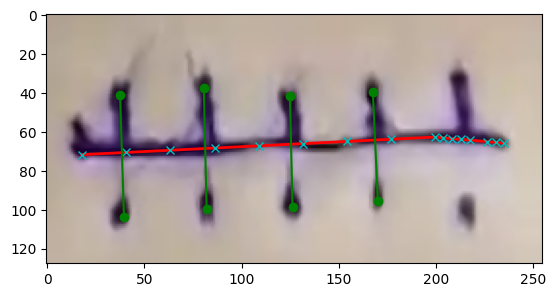

In [68]:
# INIT DATASET AND AUGMENTATIONS

# blur transforms 
transform_blur = A.Compose([
    A.OneOf([
    A.AdvancedBlur(p=0.8, blur_limit=(3,7)),
    A.Blur(p=0.8, blur_limit=5), 
    A.GaussianBlur(p=0.8),
    A.MedianBlur(p=0.8, blur_limit=5),
    A.MotionBlur(p=0.8, blur_limit=5)
  ], p=0.5) 
], keypoint_params=A.KeypointParams(format='xy'))
# spatial transforms
# TODO: add vertical flip ... requires flipping the order of points as well ... separate transform 
# TODO: handle when keypoints outside of img probably condition on len(keypoinst) when forward passing
transform_geom = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.OneOf([
      # TODO: when doing rotation some point easily gets out of picture
      A.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.05, rotate_limit=20, p=0.9),
      A.PiecewiseAffine(scale=(0.015, 0.025), p=0.9),
      A.Perspective(scale=(0.01, 0.03), p=0.9)  
    ], p=0.8)
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=False))

transform_color = A.Compose([
    A.OneOf([
        # A.ChannelDropout(p=0.8),
        A.ColorJitter(p=0.8),
        A.HueSaturationValue(p=0.8),
        A.RGBShift(p=0.8),
        A.RandomBrightnessContrast(p=0.8)
    ], p=0.5)
])
transform = A.Compose([transform_color, transform_blur, transform_geom])


train_dataset = ZdoDataset(data_train_p, normalize=True, transform=transform)
val_dataset = ZdoDataset(data_valid_p, normalize=True, transform=transform)


im, points, labels = train_dataset.__getitem__(10)
# points: 16x2: [incision | stitches]
visualize(im, points[:16,:], points[16:,:], stitch_objectness=labels, unnormalize=True)

In [4]:
import torch.nn as nn
from torchvision.models import vgg11, VGG11_Weights
from torchvision.models import resnet18, ResNet18_Weights


backbone_out = 512*4*7

# define model
class Model1(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()
        self.pretrained = pretrained_model
        self.fc1 = nn.Linear(backbone_out, 512) # intermediate layer between predictons
        self.fc_points_out = nn.Linear(512, 32) # 96 coordinates for 16 incisions + 16 stitches
        self.dropout = nn.Dropout(0.4)
    
    def forward(self, x):
        x = nn.functional.relu(self.pretrained(x)) # shape (512, 4, 7) here (for (3,128,255))
        x = torch.flatten(x, start_dim=1)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.tanh(self.fc_points_out(x))
        return x
    
# load pretrained vgg + add its first module as conv feature backbone

weights = VGG11_Weights.DEFAULT
model = vgg11(weights=weights)
backbone = list(model.children())[0]
model = Model1(backbone)

# model_pretrained = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
# backbone = nn.Sequential(*list(model_pretrained.children())[:-2])
# model = Model1(backbone)

print(model)

Model1(
  (pretrained): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=Fal

epoch: 0
train-epoch 0 loss: 0.0002612710097985985 time: 9.97s
val-epoch 0 loss: 0.011193318665027619 time: 12.70s
epoch: 1
train-epoch 1 loss: 0.0003044730118286293 time: 12.13s
val-epoch 1 loss: 0.011708439886569976 time: 14.04s
epoch: 2
train-epoch 2 loss: 0.0003123008357608213 time: 9.82s
val-epoch 2 loss: 0.011825432255864143 time: 12.33s
epoch: 3
train-epoch 3 loss: 0.00033048504089887163 time: 12.48s
val-epoch 3 loss: 0.010587256401777267 time: 14.27s
epoch: 4
train-epoch 4 loss: 0.0002889424496519882 time: 9.73s
val-epoch 4 loss: 0.010279841721057892 time: 11.68s
epoch: 5
train-epoch 5 loss: 0.0002806212720090309 time: 9.66s
val-epoch 5 loss: 0.014360958337783813 time: 12.31s
epoch: 6
train-epoch 6 loss: 0.0003009981731266047 time: 9.00s
val-epoch 6 loss: 0.01097879484295845 time: 10.57s
epoch: 7
train-epoch 7 loss: 0.00025570786566333435 time: 11.32s
val-epoch 7 loss: 0.01095636561512947 time: 13.03s
epoch: 8
train-epoch 8 loss: 0.00028068592887272876 time: 8.13s
val-epoch 8 l

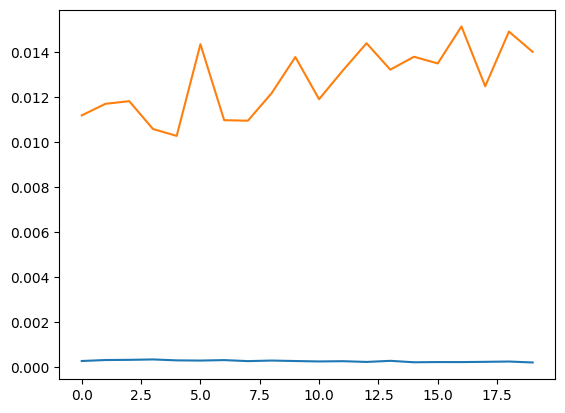

In [69]:
# TRAIN!
def train(net, dataloaders, optimizer, loss_det, loss_obj, num_epoch, device, validation=True, freq_print=10):
    net = net.to(device)
    loss_hist = np.ones((num_epoch,2))*np.inf
    # a = 0.8
    # b = 0.5
    for epoch in range(num_epoch):
        time_start = time.time()
        print(f"epoch: {epoch}")
        for loader_idx, phase in enumerate(dataloaders):
            if phase == 'train':
                net.train()
            else:
                if not validation:
                    break
                net.eval()

            loader = dataloaders[phase]
            running_loss = 0.0
            epoch_loss = 0.0
            # one batch
            for i, d in enumerate(loader, 0):
                inputs, points, labels = d
                points = points.flatten(start_dim=1) # as output of 32 neurons linear layer
                                
                inputs, points, labels = inputs.to(device), points.to(device), labels.to(device)
                
                #zero the grad!
                optimizer.zero_grad()

                out_p = net(inputs[:,:32])

                # compute loss
                N = labels.sum() #number of correct
                
                incision_loss = loss_det(out_p, points[:,:32])

                loss = incision_loss

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
         
                # statistics
                running_loss += loss.item()
                epoch_loss += loss.item()

                if i % freq_print == (freq_print-1): 
                    print(f'{phase}: [{epoch + 1}, {i + 1:5d}] loss: {running_loss / freq_print:.3f}')
                    running_loss = 0.0 

            # normalize metrics by the size of data
            epoch_loss /= len(dataloaders[phase].dataset)
            loss_hist[epoch,loader_idx] = epoch_loss
            epoch_time = time.time() - time_start
            print(f"{phase}-epoch {epoch} loss: {epoch_loss} time: {epoch_time:.2f}s")
            
    print("training finished")
    plt.plot(loss_hist)
    
    return loss_hist

# setup dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=45, shuffle=True, num_workers=4)
val_dataloder = DataLoader(val_dataset, batch_size=10, shuffle=True, num_workers=4)

# train setup
dataloaders={'train': train_dataloader, 'val':val_dataloder}
num_epoch = 20
# optimizer = optim.SGD(model.parameters(), lr=0.1, momeentum=0.9)
optimizer = optim.AdamW(model.parameters(), lr=0.0001)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

loss = nn.MSELoss()
loss_objectness = nn.BCELoss()

loss_hist = train(model, dataloaders, optimizer, loss, loss_objectness, num_epoch, device)

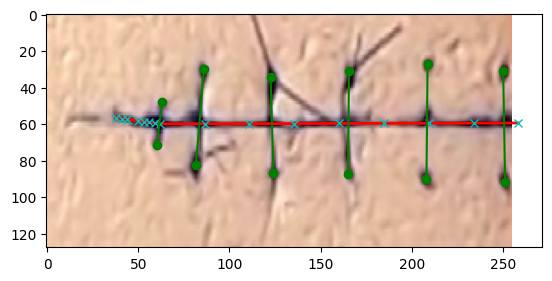

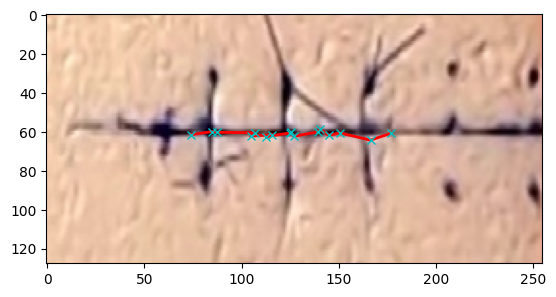

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [76]:
im, points_gt, stitchness_gt = val_dataset.__getitem__(7)
visualize(im, points_gt[:16,:], points_gt[16:,:], stitch_objectness=stitchness_gt.numpy(), unnormalize=True)


# prediction:
model.eval()
im2 = (im.unsqueeze(0)).to(device)
points_pred = model(im2)
points_pred = points_pred.reshape([16,2]).detach().cpu()
visualize(im, points_pred[:16,:], stitches=None, stitch_objectness=None, unnormalize=True)
plt.figure()

In [42]:
model.eval()
im = (im/128.0) - 1
im2 = (im.unsqueeze(0)).to(device)
points_pred = model(im2)
points_pred = points_pred.reshape([16,2]).detach().cpu()

In [43]:
points_pred += 1
points_pred[:,0] *= (255.0 /2)
points_pred[:,1] *= (128.0 /2)

In [67]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, 'checkpoints/vgg_incision_only_100.pth')

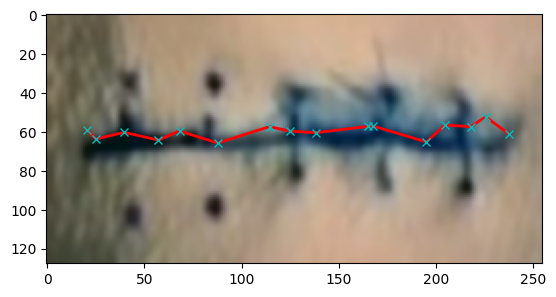

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [23]:
checkpoint = torch.load('checkpoints/vgg_incision_only.pth')

backbone = vgg11()
backbone = list(backbone.children())[0]
model_loaded = Model1(backbone)
model_loaded.load_state_dict(checkpoint['model_state_dict'])
model_loaded.eval()
model_loaded.to('cpu')

im2 = (im.unsqueeze(0)).to(device)
points_pred = model(im2)
points_pred = points_pred.reshape([16,2]).detach().cpu()
visualize(im, points_pred[:16,:], stitches=None, stitch_objectness=None, unnormalize=True)
plt.figure()

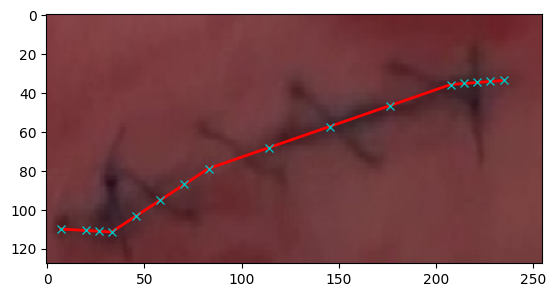

In [ ]:
im, incision = train_dataset.get_raw_item('77')
visualize(im, incision)

In [ ]:
len(incision)

16

In [ ]:
# hmmm
train_ids = list(train_dataset.images.keys())
valid_ids = list(val_dataset.images.keys())

print(f"train size: {len(train_ids)}")
for k in train_ids:
    if k in valid_ids: print("ajaaj")

train size: 116
